# Analysis tools and quality control (QC)

<style>
    .large-link {
        font-size: 30px;
        font-family: Arial, sans-serif;
        color: #333;
        text-decoration: none;
    }
</style>
<a href="../assets/pdf/04_scanpy_workflow.pdf" target="_blank" class="large-link">Download Presentation: Introduction to scanpy</a>

In this exercise, you will begin to learn about the standard workflow for analyzing scRNA-seq count data in Python. As single cell data is complex and often tailored to the particular experimental design, so there is not one “correct” approach to analyzing these data. However, certain steps have become accepted as a sort of standard "best practice." 

A useful overview on the current best practices is found in the articles below, which we also borrow from in this tutorial. We thank the authors for compiling such handy resources!

Current best practices in single-cell RNA-seq analysis are explained in a recent [Nature Review](https://www.nature.com/articles/s41576-023-00586-w)

Accompanying this review is an [online webpage](https://www.sc-best-practices.org/preamble.html), which is still under development but can be quite handy nonetheless:

## Learning outcomes
**After having completed this chapter you will be able to:**

- Load single cell data into Python.
- Explain the basic structure of a AnnData object and extract count data and metadata.
- Calculate and visualize quality measures based on:
    - mitochondrial genes
    - ribosomal genes
    - hemoglobin genes
    - relative gene expression
- Interpret the above quality measures per cell.
- Perform cell filtering based on user-selected quality thresholds.

## Loading scRNAseq data

After the generation of the count matrices with cellranger, the next step is the data analysis. The scanpy package is currently the most popular software in Python to do this. To start working with scanpy, you must import the package into your Jupyter notebook as follows:

In [1]:
import scanpy as sc

An excellent resource for documentation on scanpy can be found on the software page at the following [link](https://scanpy.readthedocs.io/en/stable/).

There are some supplemental packages for data handling and visualization that are also very useful to import into your notebook as well.

In [2]:
import pandas as pd # for handling data frames (i.e. data tables)
import numpy as np # for handling numbers, arrays, and matrices
import matplotlib.pyplot as plt # plotting package

First, we will load a file specifying the different samples, and create a dictionary "datadirs" specifying the location of the count data:

In [ ]:
sample_info = pd.read_csv("course_data/sample_info_course.csv")

datadirs = {}
for sample_name in sample_info["SampleName"]:
    if "PBMMC" in sample_name:
        datadirs[sample_name] = "course_data/count_matrices/" + sample_name + "/outs/filtered_feature_bc_matrix"

To run through a typical scanpy analysis, we will use the files that are in the directory outs/filtered_feature_bc_matrix. This directory is part of the output generated by CellRanger.

We will use the list of file paths generated in the previous step to load each sample into a separate AnnData object. We will then store all six of those samples in a list called adatas, and combine them into a single AnnData object for our analysis.

In [4]:
adatas = []
for sample in datadirs.keys():
    print("Loading: ", sample)
    curr_adata = sc.read_10x_mtx(datadirs[sample]) # load file into an AnnData object
    curr_adata.obs["sample"] = sample
    curr_adata.X = curr_adata.X.toarray()
    adatas.append(curr_adata)
    
adata = sc.concat(adatas) # combine all samples into a single AnnData object
adata.obs_names_make_unique() # make sure each cell barcode has a unique identifier

Loading:  PBMMC_1
Loading:  PBMMC_2
Loading:  PBMMC_3


/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


The AnnData object is similar to a detailed spreadsheet! Some basic commands to view the object are shown below. For a new dataset, there will be little to no metdata other than Cell IDs and gene names, but as you perform analyses, the metadata fields will be populated with more detail.

**Exercise 1**: Check what’s in the adata object, by typing `adata` in the Python console. How many gene features are in there? And how many cells?

<button onclick="toggleVisibility('answer1')">Click for Answer</button>
<div id="answer1" style="display:none;">
<strong>Answer:</strong> typing <code>adata</code> should return:
<pre>
    AnnData object with n_obs × n_vars = 6946 × 33694
    obs: 'sample'
</pre>
You can also confirm the number of observations (cells) and variables (genes/features) using the commands below:
<pre>
    adata.n_obs # number of cells
    adata.n_vars # number of genes
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script>

## The AnnData object

The `adata` object we have created has the class AnnData. The object contains the single-cell count matrix, accessible with the command `adata.X` as well as various slots that specify sample metadata. This metadata is pretty limited when first loading the output from cellranger, but we will populate it with more useful information (i.e., cluster information) in later steps of the analysis.

To access the metadata corresponding to the cells (i.e. cell barcode, batch), you can enter the command `adata.obs`. To access the metadata corresponding to the genes (i.e, gene names, chromosome, etc), you can enter the command `adata.var`. These commands return a `pandas.dataframe` object. This data frame can be manipulated using any functions from the `pandas` package, including sum(), mean(), groupby(), and value_counts().

In [5]:
adata.X # view the count matrix (rows x columns, cells x genes)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
adata.obs.head() # view a pandas data frame containing metadata on the cells

,sample
AAACCTGCAGACGCAA-1,PBMMC_1
AAACCTGTCATCACCC-1,PBMMC_1
AAAGATGCATAAAGGT-1,PBMMC_1
AAAGCAAAGCAGCGTA-1,PBMMC_1
AAAGCAACAATAACGA-1,PBMMC_1


In [7]:
adata.var.head() # view a pandas data frame containing metadata on the cells

""
RP11-34P13.3
FAM138A
OR4F5
RP11-34P13.7
RP11-34P13.8


**Exercise 2**: Use the pandas `value_counts()` function to determine how many cells were collected for each of the six samples saved into your adata object? Keep in mind, since this is cell-specific metadata, we will want to work with the data frame returned by typing `adata.obs`.

<button onclick="toggleVisibility('answer2')">Click for Answer</button>
<div id="answer2" style="display:none;">
<strong>Answer:</strong> You can run the command <code>adata.obs["sample"].value_counts()</code> to view the number of cells per sample.

The output should be:
<pre>
    sample
    PBMMC_2         3105
    PBMMC_3         2229
    PBMMC_1         1612
    Name: count, dtype: int64
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script>

## Quality control

In general, quality control (QC) should be done before any downstream analysis is performed. How the data is cleaned will likely have huge effects on downstream results, so it’s imperative to invest the time in choosing QC methods that you think are appropriate for your data! There are some "best practices" but these are by no means strict standards and also have certain limitations: https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

Goals:
- Filter the data to only include cells that are of high quality. This includes empty droplets, cells with a low total number of UMIs, doublets (two cells that got the same cell barcode), and dying cells (with a high fraction of mitochondrial counts).

Challenges:
- Delineating cells that are poor quality from less complex cell types
- Choosing appropriate thresholds for filtering, so as to keep high quality cells without removing biologically relevant cell types or cell states.

Before analyzing the scRNA-seq gene expression data, we should ensure that all cellular barcode data corresponds to viable cells. Cell QC is commonly performed based on three QC covariates:
- Library size: the number of counts per barcode (count depth)
- Detected genes: the number of genes per barcode
- Mitochondrial counts: the fraction of counts from mitochondrial genes per barcode.

Library size: First, consider the total number of counts (UMIs) detected per cell. Cells with few counts are likely to have been broken or failed to capture a cell, and should thus be removed. Cells with many counts above the average for a sample are likely to be doublets, or two cells encapsulated in the gel bead during the protocol.

**Exercise 3**: Using the scanpy and matplotlib packages, visualize a histogram of the distribution of total counts per cell in the dataset. Save this information as metadata to the adata.obs dataframe using a command such as: `adata.obs["n_counts"] = n_counts_array`. Choose lower and upper boundaries to filter out poor-quality cells and doublets.

The histogram function is: `plt.hist()`
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

Tip: each function, such as `plt.hist()` has a set of required arguments. To view those required arguments, as well as an optional arguments, from your jupyter notebook, simply click with your cursor between the `()` parenthesis of the function, and tab `tab+shift` on your keyboard.

In [8]:
n_counts_array = adata.X.sum(axis=1) # axis=1 to sum over genes, axis=0 to sum over cells
adata.obs['n_counts'] = n_counts_array

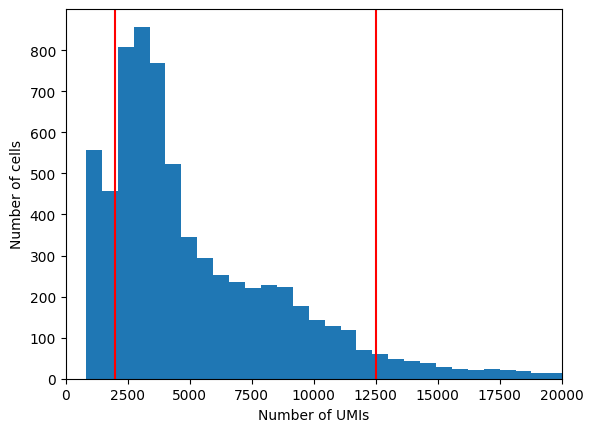

In [9]:
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Number of UMIs")
plt.ylabel("Number of cells")
plt.axvline(2000, c="r") # choose a lower cutoff for total UMIs
plt.axvline(12500, c="r") # choose a upper cutoff for total UMIs
plt.xlim(0, 20000)
plt.show()

**Exercise 4**: Using the scanpy and matplotlib packages, visualize a histogram of the distribution of total genes expressed per cell in the dataset. Save this information as metadata to the adata.obs dataframe using a command such as: `adata.obs["n_genes"] = n_genes_array`. Choose lower and upper boundaries to filter out low-diversity cells.

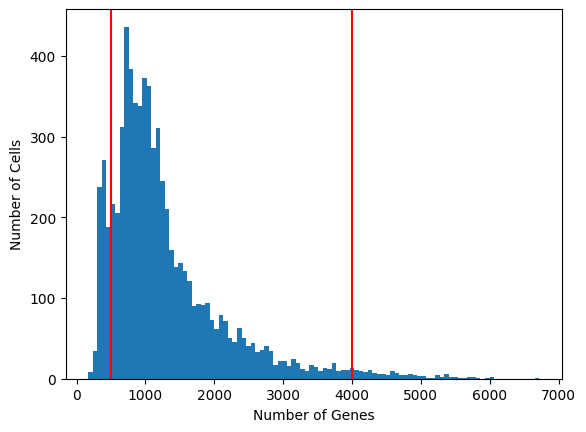

In [10]:
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(500, c="r") # choose a lower cutoff for number of detected genes
plt.axvline(4000, c="r") # choose a upper cutoff for number of detected genes
plt.xlabel("Number of Genes")
plt.ylabel("Number of Cells")
plt.show()

Next, we want to consider filtering cells with high levels of certain classes of genes, namely mitochondrial, ribosomal, and/or hemoglobin genes. There is a different rationale for filtering cells with high levels of these gene classes:

- Mitochondrial genes: If a cell membrane is damaged, it looses free RNA quicker compared to mitochondrial RNA, because the latter is part of the mitochondrion. A high relative amount of mitochondrial counts can therefore point to damaged cells (Lun et al. 2016).
- Ribosomal genes: Are not rRNA (ribosomal RNA) but is mRNA that code for ribosomal proteins. They do not point to specific issues, but it can be good to have a look at their relative abundance. They can have biological relevance (e.g. Caron et al. 2020).
- Hemoglobin genes: these transcripts are very abundant in erythrocytes. Depending on your application, you can expect ‘contamination’ of erythrocytes and select against it.

In order to have an idea about the relative counts of these type of genes in our dataset, we can calculate their expression as relative counts in each cell. We do that by selecting genes based on patterns (e.g. ^MT- matches with all gene names starting with MT, i.e. mitochondrial genes):

In [11]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [12]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20]) # this step can be a little slow to run

**Exercise 5**: Run the commands and check out the metadata data frame at `adata.obs`. What has changed?

<button onclick="toggleVisibility('answer5')">Click for Answer</button>
<div id="answer5" style="display:none;">
<strong>Answer:</strong> If we type <code>adata.obs</code>, a lot more metadata is present compared to before! This should include the following columns:


The output should be:
<pre>
    pct_counts_mt
    total_counts_mt
    pct_counts_ribo
    total_counts_ribo
    pct_counts_hb
    total_counts_hb
</pre>
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script>

## Plotting experiment metadata

**Exercise 6**: Using scanpy's `sc.pl.violin` function, create a violin plot of the percent of counts corresponding to mitochondrial, ribosomal, and hemoglobin genes per cell. Choose an upper boundary to filter out poor quality cells with high mitochondrial counts. Note that we might want to view the results as a separate violin plot for each of our six samples. To do this, please use the optional `groupby="sample"` argument.

Please note that depending on your experimental setup, it might not make sense to filter on all these criteria.

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


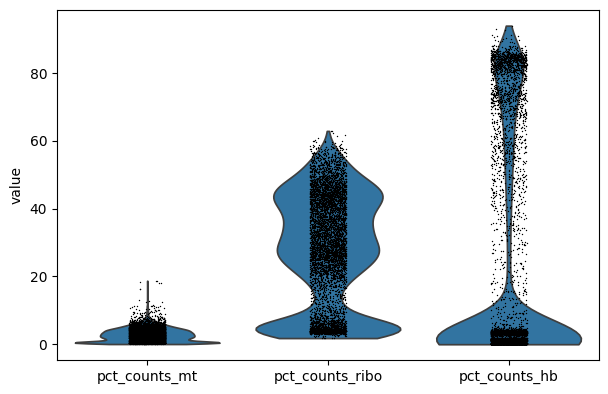

In [13]:
# Violin plots for all samples together
sc.pl.violin(adata, ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"])

/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/alex/anaconda3/envs/sctp/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and 

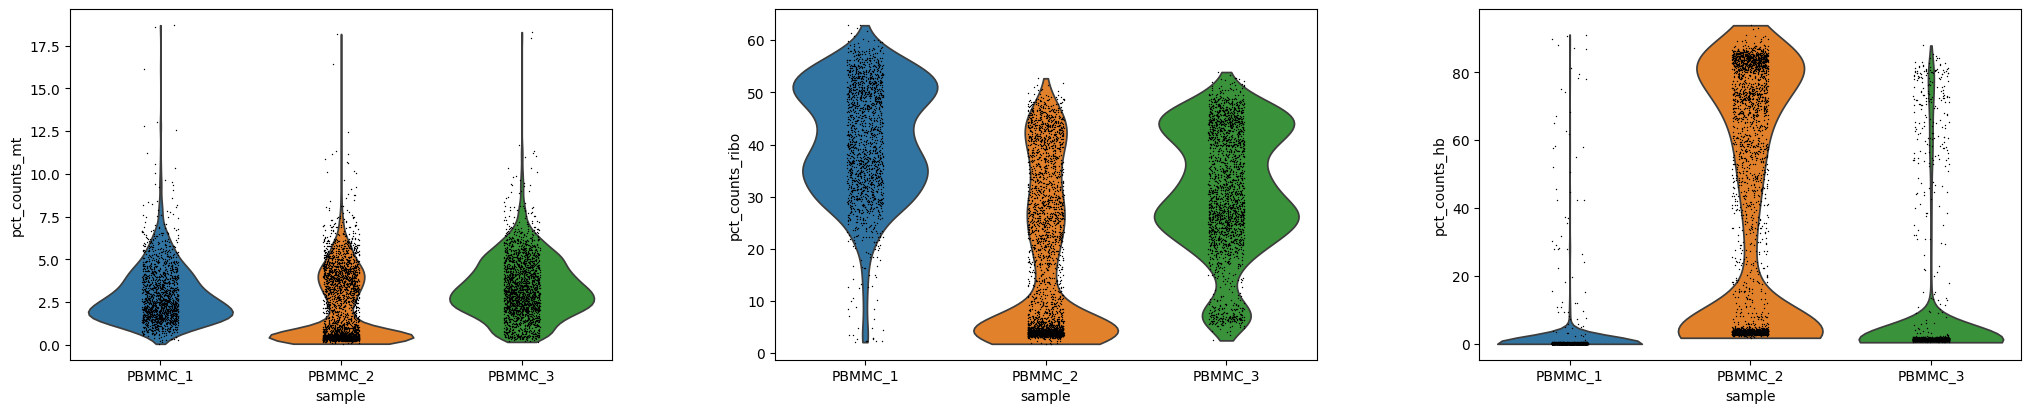

In [14]:
# Violin plots for each sample separately
sc.pl.violin(adata, ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"], groupby="sample")

You can see that PBMMC-2 is quite different from the two others, it has a group of cells with very low ribosomal counts and one with very high globin counts. Maybe these two percentages are negatively correlated? Let’s have a look, by plotting the two percentages against each other:

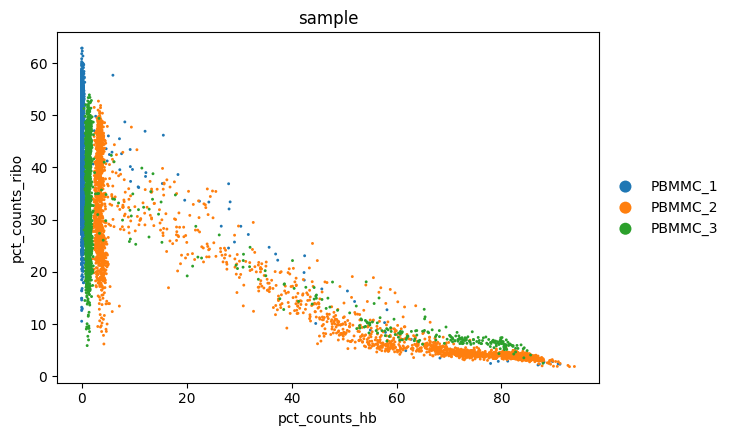

In [15]:
sc.pl.scatter(adata, x="pct_counts_hb", y="pct_counts_ribo", color='sample')

**Exercise 7**: Are they correlated? What kind of cells might have a high abundance of hemoglobin transcripts and low ribosomal transcripts?

<button onclick="toggleVisibility('answer7')">Click for Answer</button>
<div id="answer7" style="display:none;">
<strong>Answer:</strong> Yes there is a negative correlation. Erythrocytes (red blood cells) have a high abundance of hemoglobin transcripts and low abundance of ribosomal transcripts. These are most likely erythroid cells, i.e. the precursor cells for erythrocytes in the bone marrow.
<script>
function toggleVisibility(id) {
   var element = document.getElementById(id);
   if (element.style.display === 'none') {
       element.style.display = 'block';
   } else {
       element.style.display = 'none';
   }
}
</script>

## Plotting genes express as a function of total counts

We can also evaluate the relative expression of other genes in our dataset, for example, the ones that are most highly expressed. Some very highly expressed genes might point to a technical cause, and we might consider to remove them. Below you will find a simple function to generate a boxplot of relative counts per gene per cell:

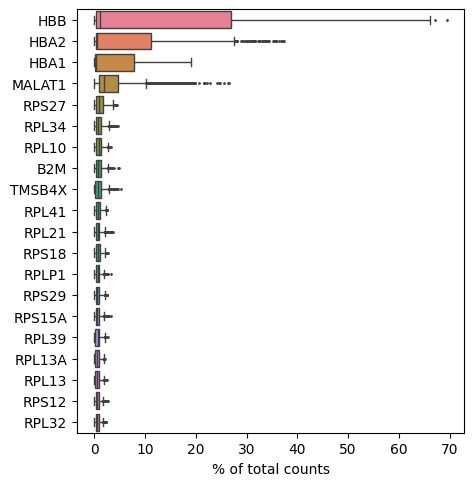

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Doublet detection

There are several tools for identifying doublets (i.e. two cells that were encapsulated with the same gel bead, obtaining the same cell barcode). Recently a benchmarking study was conducted comparing approaches: https://www.sciencedirect.com/science/article/pii/S2405471220304592

Here, we suggest you use DoubletDetection: https://doubletdetection.readthedocs.io/en/latest/tutorial.html

If you want to compare doublet detection methods, another method is scrublet: https://www.cell.com/cell-systems/pdfExtended/S2405-4712(18)30474-5

A tutorial with scanpy is described below:
https://github.com/swolock/scrublet

In [17]:
import doubletdetection

In [18]:
clf = doubletdetection.BoostClassifier()

In [19]:
# raw_counts is a cells by genes count matrix
labels = clf.fit(adata.X).predict()

# higher means more likely to be doublet
scores = clf.doublet_score()

  0%|          | 0/10 [00:00<?, ?it/s]

**Exercise 8**: Run the above steps. The variable `labels` will store the output of the doublet detection: if labels[i]==0, the cell at that position is not a doublet, whereas if labels[i]==1, then the cell at that position is a doublet. How many doublets are predicted? Can you assign this `labels` metadata to your `adata` object with `adata.obs["is_doublet"]` and then use `value_counts()` to see the number of doublets?

In [20]:
adata.obs["is_doublet"] = labels

In [21]:
adata.obs["is_doublet"].value_counts()

is_doublet
0.0    6879
1.0      59
Name: count, dtype: int64

Finally, let's filter out the doublet cells!

In [22]:
adata = adata[adata.obs["is_doublet"]==0].copy()

In [23]:
adata # is now populated with some more metadata from the QC steps above

AnnData object with n_obs × n_vars = 6879 × 33694
    obs: 'sample', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'is_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors'

## Cell Filtering

**Exercise 9**: Once you have selected your QC filtering criteria, you need to actually do the filtering! You can do this either (1) using the QC thresholds you selected above or (2) obtaining automated thresholds using scanpy quality control metrics. Whether you choose the (1) or (2) approach is up to you. Unfortunately, there is not much automation in the quality control steps at this stage, although there are ongoing efforts by the single cell community to create a more unbiased QC approaches. We suggest manually selecting your filtering thresholds using the plots generated above as a guide.

Use the following scanpy quality control checks to filter out poor quality cells based either (1) your semi-subjective criteria OR (2) the somewhat automated approach offered described here: https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

Hint: you can also filter an AnnData object using indexing approaches, as with numpy arrays and pandas data frames. For instance, the following command filters genes (columns) on a qc metric for percent mitochondrial counts: `adata = adata[adata.obs['pct_counts_mt'] < 0.08, :].copy()`

In [24]:
sc.pp.filter_cells(adata, min_counts=??) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_counts=??) # apply threshold from above to actually do the filtering

In [25]:
sc.pp.filter_cells(adata, min_genes=??) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_genes=??) # apply threshold from above to actually do the filtering

In [26]:
adata = adata[adata.obs['pct_counts_mt'] <= 8, :].copy() # apply threshold from above to actually do the filtering
# the authors of the original study used 8% as their threshold here.

In [27]:
adata

AnnData object with n_obs × n_vars = 5469 × 33694
    obs: 'sample', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'is_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'sample_colors'

**Exercise 10**: We have been discussing cell filtering, but you may also want to filter out genes that are not detected in your data! For this, you can use the function `sc.pp.filter_genes`. Try doing this to filter out genes expressed in fewer than 1% of your total cells. How many genes are removed (you can check the value of `adata.n_vars` before and after filtering with `sc.pp.filter_genes`.

In [28]:
n_cells = adata.n_obs
sc.pp.filter_genes(adata, min_cells=int(n_cells*0.01)) # specify min cells equal to 1% of your total cell count

In [29]:
adata

AnnData object with n_obs × n_vars = 5469 × 10839
    obs: 'sample', 'n_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'is_doublet'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'sample_colors'

**Exercise 11**: You have finished this set of exercises! One important final step: in case you want to save your results at any time, you can use the command `adata.write_h5ad()` to save your AnnData object for later use. Try doing this here, so that you can load the adata object into the next Jupyter notebook tutorial on Normalization and Scaling.

In [30]:
adata.write_h5ad("PBMC_analysis_SIB_tutorial.h5ad") # feel free to choose whichever file name you prefer!